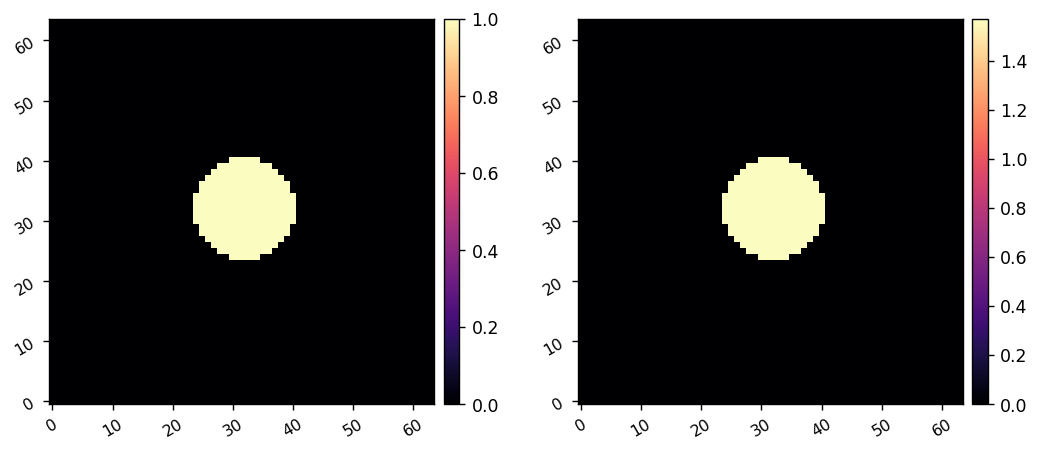

In [11]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import copy

import poppy

import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

wavelength = 633*u.nm
pupil_diam = 10*u.mm
fl = 500*u.mm

npix = 256
oversample = 16
N = int(npix*oversample)

pwf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=oversample) # pupil wavefront
ap = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(pwf)
mask = ap.astype(bool)
tt_modes = poppy.zernike.arbitrary_basis(ap, nterms=3, outside=0)[1:]

zwfs_pixelscale_lamD = 1/oversample
y,x = (xp.indices((N, N)) - N//2)*zwfs_pixelscale_lamD
r = xp.sqrt(x**2 + y**2)
M = r<1.06/2
zwfs_mask = xp.exp(1j * xp.pi/2 * M)
imshow2(M, xp.angle(zwfs_mask), npix=64)

def fft(arr):
    return xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(arr)))

def ifft(arr):
    return xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(arr)))

def snap_zwfs(pupil, use_zwfs=True):
    fpwf = fft(pupil)
    fpwf *= zwfs_mask if use_zwfs else 1
    ppwf = ifft(fpwf)
    return xp.abs(ppwf)**2


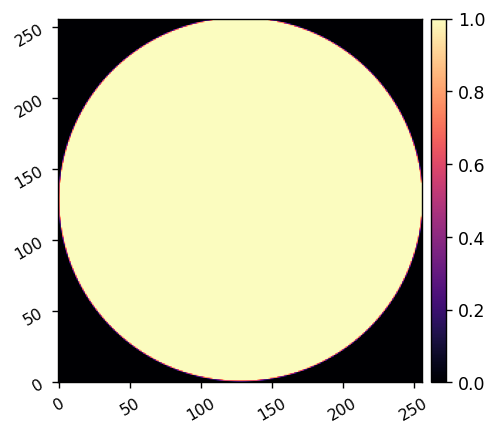

In [3]:
P = snap_zwfs(ap, use_zwfs=False)
imshow1(P, npix=npix)

In [4]:
b = ifft(M * fft(ap))

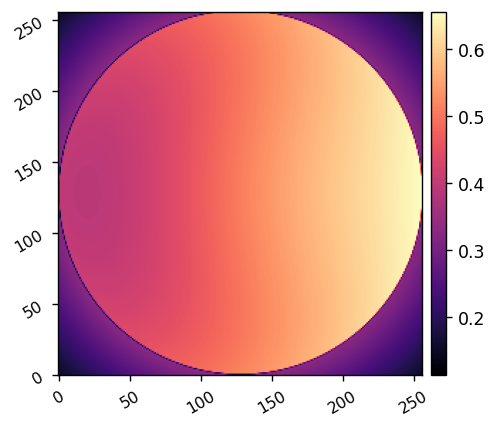

In [5]:
# Ic = snap_zwfs(ap)
Ic = snap_zwfs(ap * xp.exp(1j * 2*xp.pi / wavelength.to_value(u.m) * 10e-9 * tt_modes[0] ))
imshow1(Ic, npix=npix)

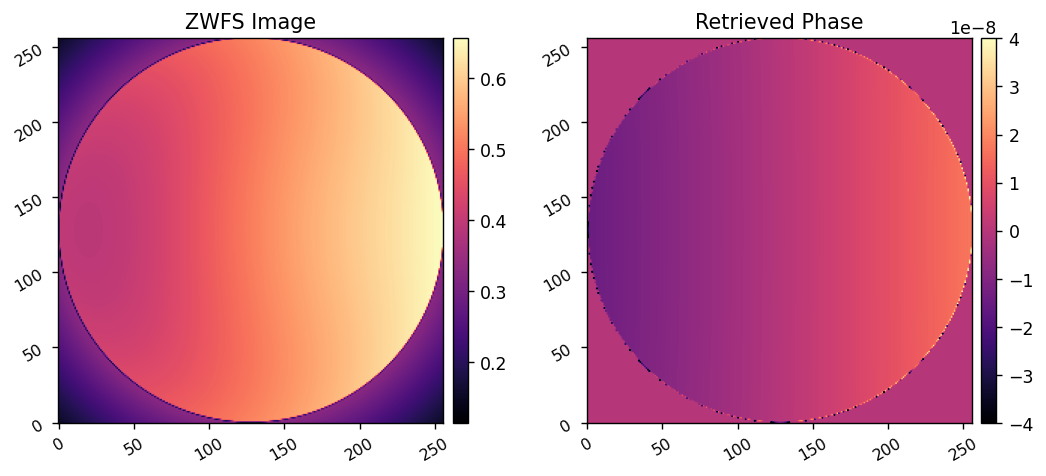

In [42]:
imshow2(Ic, opd* data_mask, 'ZWFS Image', 'Retrieved Phase', npix=npix, 
        vmin2=-vmax2, vmax2=vmax2)

In [6]:
phi = ( Ic - P**2 - 2*b**2 + 2*P*b ) / (2*P*b)

8.64407832928862e-09


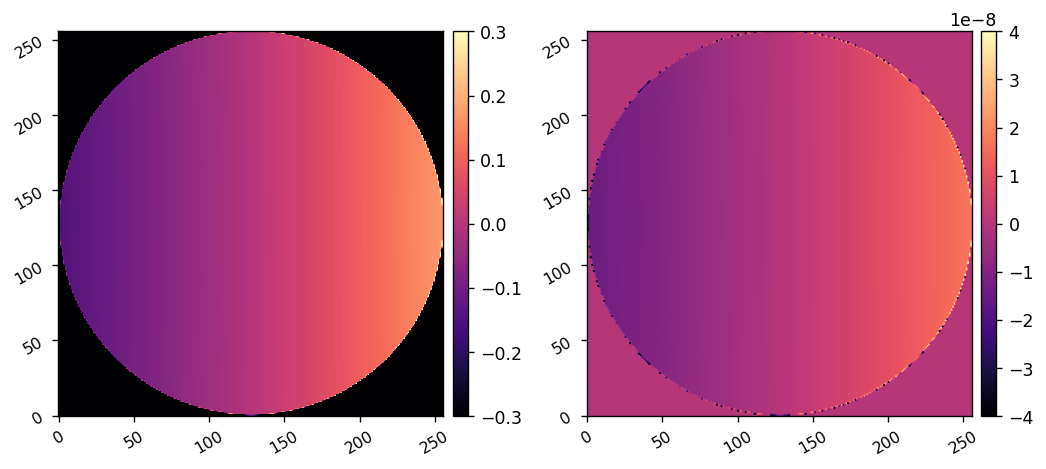

In [40]:
opd = phi.real * wavelength.to_value(u.m)/(2*np.pi)

data_mask = (xp.abs(opd) < 1e-7) * mask
rms = xp.sqrt(xp.mean(xp.square(opd[data_mask])))
print(rms)

vmax1 = 0.3
vmax2 = 40e-9
imshow2(phi.real, opd* data_mask, npix=npix, 
        vmin1=-vmax1, vmax1=vmax1,
        vmin2=-vmax2, vmax2=vmax2)

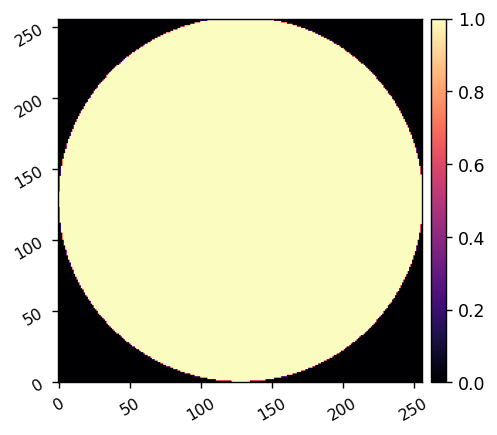

In [33]:
data_mask = (xp.abs(opd) < 1e-7) * mask
imshow1(data_mask, npix=npix)
rms = xp.sqrt(xp.mean(xp.square(opd[data_mask])))

array(8.64407833e-09)